In [1]:
#install astra
!wget https://repo.anaconda.com/archive/Anaconda3-2020.02-Linux-x86_64.sh && bash Anaconda3-2020.02-Linux-x86_64.sh -bfp /usr/local
import sys
sys.path.insert(0,"/usr/local/lib/python3.7/site-packages/")
!conda install -c astra-toolbox/label/dev astra-toolbox

--2021-10-31 11:25:03--  https://repo.anaconda.com/archive/Anaconda3-2020.02-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 546910666 (522M) [application/x-sh]
Saving to: ‘Anaconda3-2020.02-Linux-x86_64.sh’

Anaconda3-2020.02-L 100%[===================>] 521.57M   155MB/s    in 3.4s    

2021-10-31 11:25:07 (154 MB/s) - ‘Anaconda3-2020.02-Linux-x86_64.sh’ saved [546910666/546910666]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.12

In [2]:
import astra
import os
import time
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
# Utilities for working with remote data
import requests
from io import BytesIO
import zipfile
# Image processing shortcuts
import imageio
import cv2
import copy
from imageio import get_writer
import tensorflow as tf
from IPython import display
from PIL import Image
from google.colab import files
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import save_img

In [3]:
#definisco dim dei volumi considerati (e quindi dei rispettivi impianti)
H=220
W=220
D=208

In [4]:
def project(volume):
# Configuration of projection geometry
  distance_source_origin = 571  # [mm]  
  distance_origin_detector = 408  # [mm] 
  detector_pixel_size = 1.2# [mm]  
  detector_rows =384 # Vertical size of detector [pixels].  
  detector_cols = 384 # Horizontal size of detector [pixels].
  num_of_projections = 360
  angles = np.linspace(-np.pi/2, np.pi/2, num_of_projections)
  vol_geom = astra.creators.create_vol_geom((D,H,W)) 
  #(208,220,220)  #astra chiede:y,x,z , asse di rotazione per astra è lungo asse y e detect e sorg sono in asse x 
  #nel nostro caso l'asse di rotazione è lungo l'asse z che quindi deve essere la prima dimensione quando
  #si da il volume a questa funzione 
  vol_id = astra.data3d.create('-vol', vol_geom, data=volume)

  proj_geom=astra.create_proj_geom('cone', 1.2, 1.2, detector_rows, detector_cols, angles,distance_source_origin ,distance_origin_detector)
  projections_id, projections = astra.creators.create_sino3d_gpu(vol_id, proj_geom, vol_geom)
  return projections
def reconstruct(proj, alg='FDK_CUDA'):
  distance_source_origin = 571  # [mm] 
  distance_origin_detector = 408  # [mm] 
  detector_pixel_size = 1.2  # [mm]  
  detector_rows = 384  # Vertical size of detector [pixels].  
  detector_cols = 384 # Horizontal size of detector [pixels].
  num_of_projections = 360
  angles = np.linspace(-np.pi/2, np.pi/2, num_of_projections)
  proj_geom=astra.create_proj_geom('cone', 1.2, 1.2, detector_rows, detector_cols, angles,distance_source_origin , distance_origin_detector)
  proj_id = astra.data3d.create('-sino', proj_geom, proj)
  rec_vol_geom = astra.creators.create_vol_geom((D,H,W) )
  rec_vol_id = astra.data3d.create('-vol', rec_vol_geom, data=0)
  alg_cfg = astra.astra_dict(alg)
  alg_cfg['ProjectionDataId'] = proj_id
  alg_cfg['ReconstructionDataId'] = rec_vol_id
  alg_id = astra.algorithm.create(alg_cfg)
  astra.algorithm.run(alg_id)
  return astra.data3d.get(rec_vol_id)

In [8]:
#importa proiezioni corrette dalla prima rete e crea dizionario proj_rete con queste proiezioni
#proj_rete[0] ha dim 384,360,384
proj_rete=dict()
n=1  #numero di proiezioni corrette da considerare
for i in range(n):
  j=i+2 #indice delle proiezioni da scaricare
  ctr_m = requests.get( 
    f'http://144.91.118.156/projcorr19_{j}.zip')
  ctzip_m = BytesIO(ctr_m.content)
  ct_fdata_m = zipfile.ZipFile(ctzip_m)
  vol = np.array([imageio.imread(ct_fdata_m.open(fname)) for fname in ct_fdata_m.namelist()])
  vol=np.transpose(vol,(1,0,2))
  proj_rete[i]=vol


In [9]:

#creazione di un dizionario proj con le proiezioni dei volumi corretti
import astra
proj=dict()
m=1 #numero di volumi considerati
for i in range(m):
  j=i+1  #indice del volume
  ctr = requests.get( 
    f'http://144.91.118.156/vol_{j}.zip')
  ctzip = BytesIO(ctr.content)
  ct_fdata= zipfile.ZipFile(ctzip)
  ct_idata = np.array([imageio.imread(ct_fdata.open(fname)) for fname in ct_fdata.namelist()])
  vol=np.transpose(ct_idata,(1,0,2))
  proj_true=project(vol)
  proj[i]=proj_true


In [25]:
#ottengo dizionario con i volumi degli impianti
masks=dict()
g=1  #numero di impianti
for i in range(g):
  j=i+2  #indice impianti da scaricare
  ctr_m = requests.get( 
    f'http://144.91.118.156/imp_{j}.zip')
  ctzip_m = BytesIO(ctr_m.content)
  ct_fdata_m = zipfile.ZipFile(ctzip_m)
  ct_idata_m = np.array([imageio.imread(ct_fdata_m.open(fname)) for fname in ct_fdata_m.namelist()])
  vol_m=np.transpose(ct_idata_m,(1,0,2))
  masks[i]=vol_m


In [26]:
#crea proiezioni degli impianti ed il dizionario

mask_projections=dict()

for i in range(g):
  mask=masks[i]
  mask_proj=project(mask)
  mask_proj[mask_proj>0]=255
  mask_projections[i]=mask_proj


(384, 360, 384)


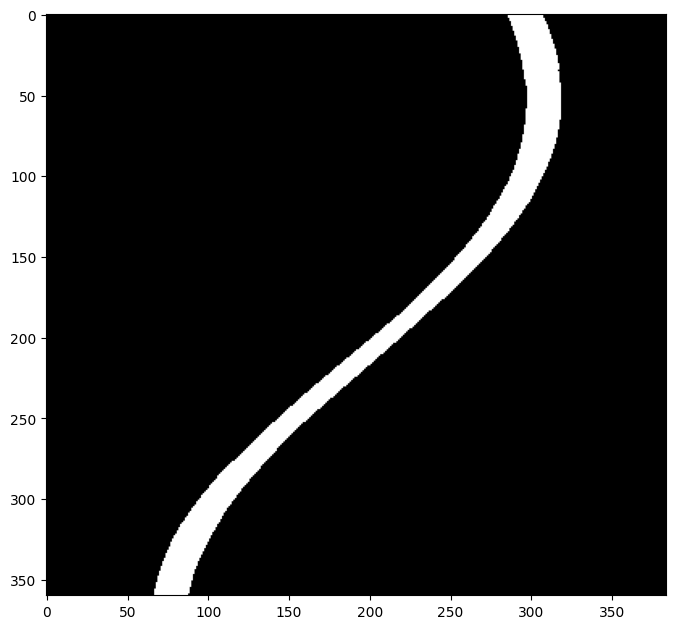

In [23]:
#show sinogram mask image
ma=mask_projections[0]
print(ma.shape)
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(ma[145,:,:], cmap=plt.cm.gray)

In [27]:
#salva immagini
#MASK_PROJECTIONS: sinogrammi degli impianti
for i in range(g): 
  s=i+1  
  projections=mask_projections[i]
  cv2.normalize(projections, projections, 0, 255, cv2.NORM_MINMAX)
  projections = projections.astype(np.uint8)
  k=384
  for j in range(k):
   projection = projections[j, :,:]
   l=j+100
   img = Image.fromarray(projection,'L')
   img.save(f'mask_{s}_sino_{l}.png' )

#PROJ_RETE:sinogrammi ottenuti dalla correzione delle proiezioni con la prima rete
for i in range(m):
  s=i+1   #salvo le 5 priezioni da rete
  projections=proj_rete[i]
  print(projections.shape)
  cv2.normalize(projections, projections, 0, 255, cv2.NORM_MINMAX)
  projections = projections.astype(np.uint8)
  k=384
  for j in range(k):
   projection = projections[j,:,:]
   l=j+100
   img = Image.fromarray(projection,'L')
   img.save(f'rete_caso_{s}_sino_{l}.png' )

#PROJ: sinogrammi dei volumi corretti
for i in range(n): 
  s=i+1 #salvo le 3 proj true
  projectionsA=proj[i]
  cv2.normalize(projectionsA, projectionsA, 0, 255, cv2.NORM_MINMAX)
  projectionsA = projectionsA.astype(np.uint8)
  k=384
  for j in range(k):
    projection = projectionsA[j,:,:]
    l=j+100
    img = Image.fromarray(projection,'L')
    img.save(f'true_{s}_sino_{l}.png' )

(384, 360, 384)


In [ ]:
#crea dato rete con 3 immagini per ogni proiezione corretta dalla prima rete considerata
#per ognuna ottengo 384 immagini costituite da: 
#
# sinogramma iesimo volume-sinogramma corretto da prima rete (ottenuto partendo dall iesimo volume con il jesimo impianto)-
#singramma jesimo impianto
#definisco 
#a=input considerato
#b=indice della maschera che è stata messa nell'input
#c=volume dell'input
#ad esempio in questo caso posso considerare il 2 input che ha il 2 impianto e il primo volume
a=1
b=1
c=1
for j in range(k):
  l=j+100
  images = [Image.open(x) for x in [f'true_{c}_sino_{l}.png', f'rete_caso_{a}_sino_{l}.png', f'mask_{b}_sino_{l}.png']]
  widths, heights = zip(*(t.size for t in images))
  total_width = sum(widths)
  max_height = max(heights)
  new_im = Image.new('L', (total_width, max_height))
  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

    new_im.save(f'datosin_27_{l}.png')
!zip -r datosino_27_2.zip . -i 'datosin_27*.png'
files.download( 'datosino_27_2.zip' )

  adding: datosin_27_166.png (deflated 3%)
  adding: datosin_27_244.png (deflated 0%)
  adding: datosin_27_411.png (deflated 3%)
  adding: datosin_27_376.png (deflated 3%)
  adding: datosin_27_328.png (deflated 2%)
  adding: datosin_27_100.png (deflated 83%)
  adding: datosin_27_181.png (deflated 3%)
  adding: datosin_27_254.png (deflated 0%)
  adding: datosin_27_412.png (deflated 3%)
  adding: datosin_27_373.png (deflated 3%)
  adding: datosin_27_129.png (deflated 13%)
  adding: datosin_27_212.png (deflated 2%)
  adding: datosin_27_157.png (deflated 3%)
  adding: datosin_27_395.png (deflated 3%)
  adding: datosin_27_273.png (deflated 2%)
  adding: datosin_27_396.png (deflated 3%)
  adding: datosin_27_211.png (deflated 2%)
  adding: datosin_27_216.png (deflated 2%)
  adding: datosin_27_452.png (deflated 3%)
  adding: datosin_27_203.png (deflated 2%)
  adding: datosin_27_343.png (deflated 2%)
  adding: datosin_27_462.png (deflated 4%)
  adding: datosin_27_313.png (deflated 2%)
  adding:

FileNotFoundError: ignored

In [ ]:
#for i in range(384):
 # j=i+100
 # %rm 'datosin_4_{j}.png'